In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

最优参数：{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
最优模型：DecisionTreeRegressor(max_depth=3, min_samples_leaf=2)
Test MSE: 4022.73


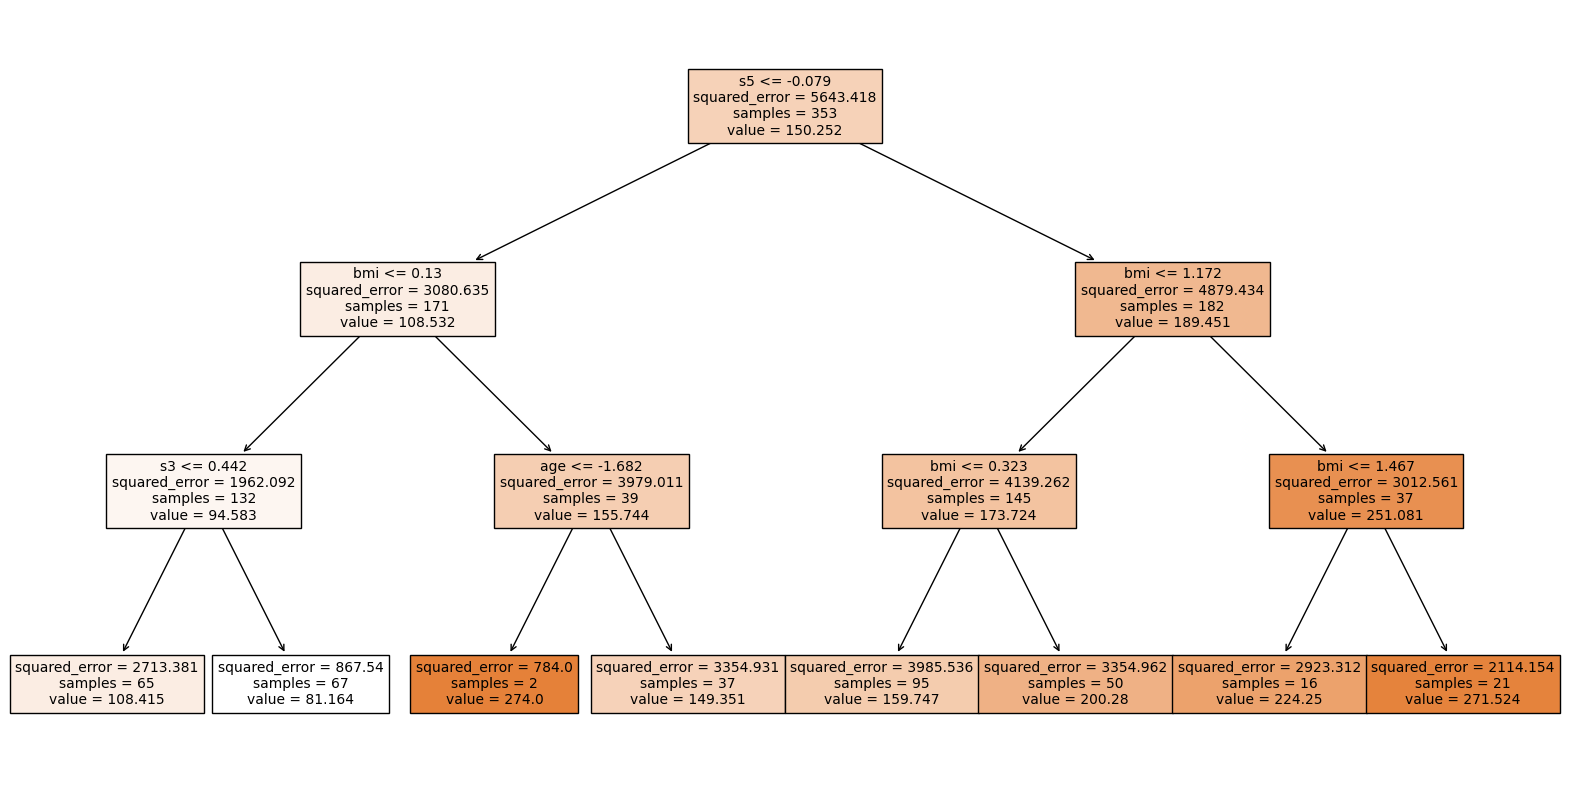

In [2]:
# 一、核心参数解析
# ·深度与复杂度控制
# max_depth：树的最大深度，限制模型复杂度。较深树易过拟合，建议初始值设为5-10。
# min_samples_split：节点分裂所需最小样本数，默认2；增大此值可抑制过拟合。
# min_samples_leaf：叶节点最小样本数，防止生成不稳定的叶节点。

# ·分箱与计算优化
# max_bins：特征分箱数（适用于Spark MLlib），默认32，影响内存消耗和计算速度。
# max_features：选择分裂时考虑的特征比例，用于随机森林变种（如Extra-Trees）

# 二、建模流程（以Scikit-learn为例）
# ​数据预处理
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 加载数据并标准化
data = load_diabetes()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# ​模型训练与评估
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


# ​超参数调优（网格搜索）
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    # 1. ​小规模数据集（<1000样本）      ​建议值：保持默认值2或略微增大（如5-10）
    # 2. ​中大规模数据集（1000-10万样本）​ 推荐范围：10-50（整数）或0.1%-0.5%（浮点数比例）
    # 3. ​超大规模数据集（>10万样本）    ​策略：按比例设置（如0.1%的样本数），或使用经验公式：min_samples_split=max(50,0.002×N)
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"最优参数：{grid_search.best_params_}")
print(f"最优模型：{grid_search.best_estimator_}")

# 初始化模型
# regressor = DecisionTreeRegressor(
#     max_depth=5,
#     min_samples_split=10,
#     random_state=42
# )
# regressor = DecisionTreeRegressor(
#     max_depth=grid_search.best_params_['max_depth'],
#     min_samples_split=grid_search.best_params_['min_samples_split'],
#     random_state=42
# )
# regressor.fit(X_train, y_train)
regressor = grid_search.best_estimator_
# 预测与评估
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.2f}")  # 示例输出：Test MSE: 3826.32[4](@ref)

# ​可视化决策树
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(20, 10))
tree.plot_tree(regressor, filled=True, feature_names=data.feature_names)
plt.show()